# Project 3: Age Prediction using Machine Learning

## Summary
This project solves a binary classification task using Decision Tree and Random Forest models. We will:
* Predict age groups based on US health and nutritional information.
* Compare the performance metrics of two Supervised-Learning Predictive Machine Learning (ML) models: Decision Tree and Random Forest.

## Dataset Description
The dataset used is “National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset” extracted from UCI Machine Learning Repository, and contains health-related features and a categorical target variable `age_group`. The goal is to classify individuals into age groups based on their health indicators.

## Approach
We implement two models:
1. **Decision Tree** (optimized with hyperparameters tuning)
2. **Random Forest** (ensemble model using bagging)

The models are evaluated using **10-fold cross-validation** based on:
- Accuracy
- Training Time
- Precision
- Recall
- F1 Score
- AUC-ROC

We also visualize results using confusion matrices and feature importance analysis.

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import time

# Load dataset
file_path = 'NHANES_age_prediction_3.csv'
df = pd.read_csv(file_path)

# Convert 'age_group' to categorical
df['age_group'] = df['age_group'].astype('category')

# Display dataset structure
df.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564,Adult,61,0,0,35.7,110,0,150,14.91
1,73568,Adult,26,0,0,20.3,89,0,80,3.85
2,73576,Adult,16,1,0,23.2,89,0,68,6.14
3,73577,Adult,32,1,0,28.9,104,0,84,16.15
4,73580,Adult,38,0,1,35.9,103,0,81,10.92


In [31]:
# Basic stats table
health_df = pd.read_csv('NHANES_age_prediction_2.csv')
formatted_df = health_df[['RIAGENDR','PAQ605','DIQ010']].replace(2,0)
health_df2 = health_df[['SEQN','age_group','RIDAGEYR']]
health_df2['RIAGENDR'] = formatted_df['RIAGENDR'].values
health_df2['PAQ605'] = formatted_df['PAQ605'].values
health_df2['BMXBMI'] = health_df['BMXBMI'].values
health_df2['LBXGLU'] = health_df['LBXGLU'].values
health_df2['DIQ010'] = formatted_df['DIQ010'].values
health_df2['LBXGLT'] = health_df['LBXGLT'].values
health_df2['LBXIN'] = health_df['LBXIN'].values

numeric_df = health_df2.select_dtypes(include='number')
numeric_df = numeric_df.drop(columns=['SEQN','RIDAGEYR'])

numeric_df3 = numeric_df[['BMXBMI','LBXGLU','LBXGLT','LBXIN']]
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_df[['BMXBMI','LBXGLU','LBXGLT','LBXIN']])
standardized_df = pd.DataFrame(standardized_data, columns = numeric_df3.columns)

numeric_df.rename(columns={'RIAGENDR': "RIAGENDR (Respondent's Gender)", 'PAQ605': "PAQ605 (Activity Level)", 'BMXBMI': "BMXBMI (Respondent's BMI)", 'LBXGLU': "LBXGLU (Respondent's Blood Glucose after fasting)", 'DIQ010' : "DIQ010 (If Respondent is diabetic)", 'LBXGLT': "LBXGLT (Respondent's Oral Health)", 'LBXIN': "LBXIN (Respondent's Blood Insulin Levels)"}, inplace=True)

stats_df3 = numeric_df.describe().T
stats_df3['Median'] = numeric_df.median()
stats_df3 = stats_df3[['min', 'max', 'mean', '50%', 'std']]
stats_df3.rename(columns={'min': 'Min', 'max': 'Max', 'mean': 'Mean', '50%': 'Median', 'std': 'Std Dev'}, inplace=True)
display(stats_df3)

C:\Users\nixon\AppData\Local\Temp\ipykernel_18820\2997182071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_df2['RIAGENDR'] = formatted_df['RIAGENDR'].values
C:\Users\nixon\AppData\Local\Temp\ipykernel_18820\2997182071.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_df2['PAQ605'] = formatted_df['PAQ605'].values
C:\Users\nixon\AppData\Local\Temp\ipykernel_18820\2997182071.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Min,Max,Mean,Median,Std Dev
RIAGENDR (Respondent's Gender),0.00,1.00,0.488586,0.00,0.499979
PAQ605 (Activity Level),0.00,1.00,0.179543,0.00,0.383891
BMXBMI (Respondent's BMI),14.50,70.10,27.955180,26.80,7.248962
LBXGLU (Respondent's Blood Glucose after fasting),63.00,405.00,99.553117,97.00,17.889834
DIQ010 (If Respondent is diabetic),0.00,1.00,0.009219,0.00,0.095591
LBXGLT (Respondent's Oral Health),40.00,604.00,114.978929,105.00,47.061239
LBXIN (Respondent's Blood Insulin Levels),0.14,102.29,11.834794,9.04,9.718812


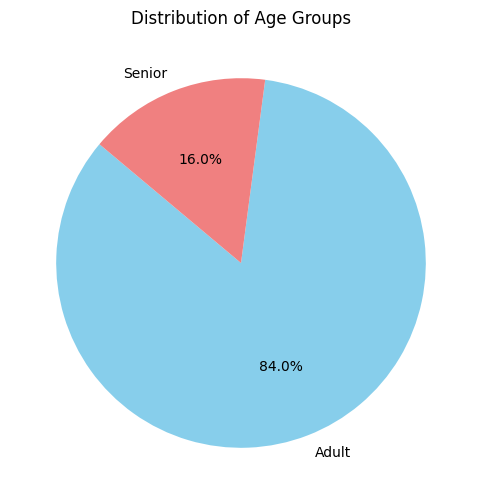

In [ ]:
# Pie chart for age group distribution
age_group_counts = df['age_group'].value_counts()
labels = age_group_counts.index.astype(str)
sizes = age_group_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Age Groups')
plt.show()

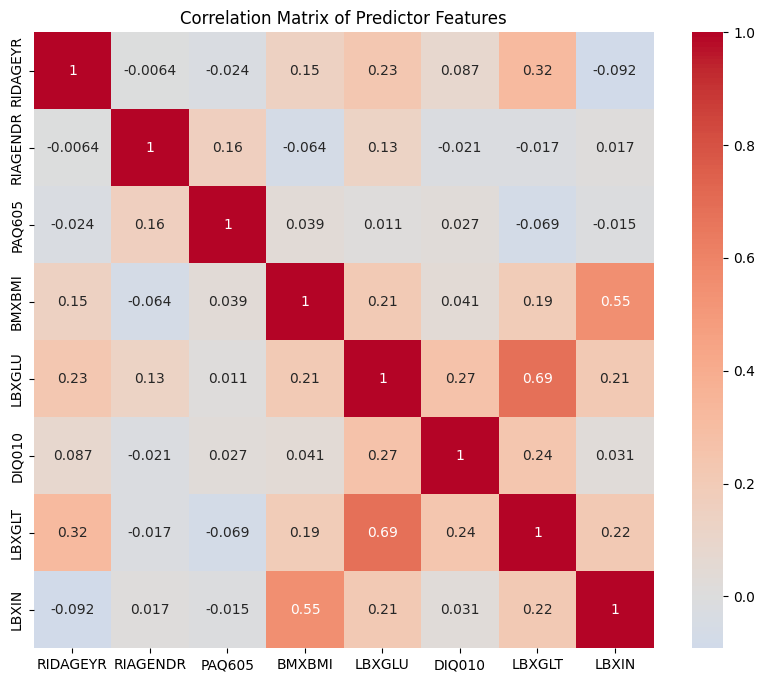

In [12]:
# Correlation matrix for numerical features
numeric_features = ['RIDAGEYR', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Predictor Features')
plt.show()

<Figure size 1000x600 with 0 Axes>

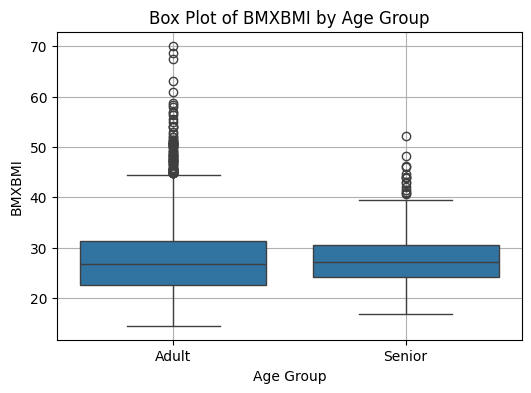

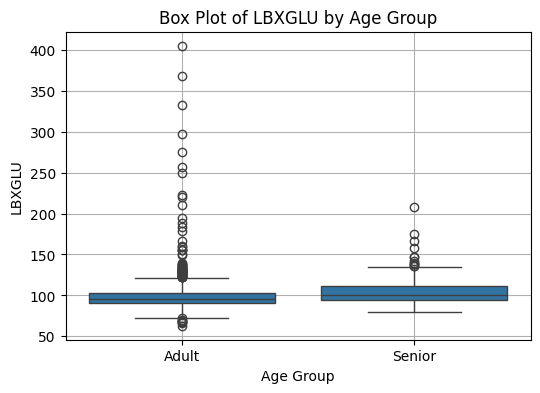

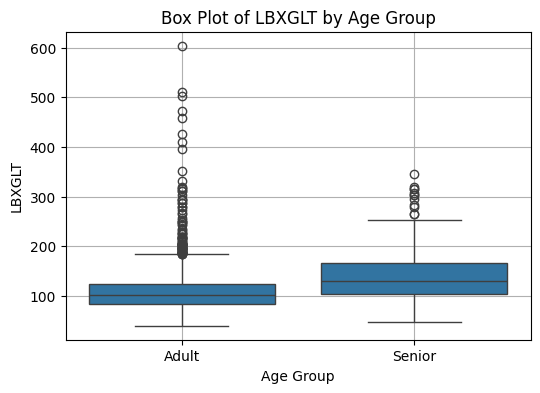

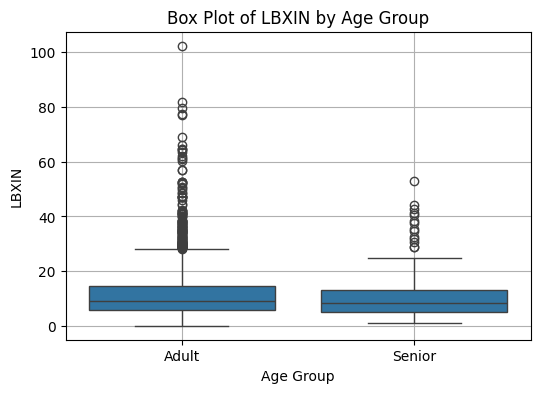

In [21]:
# Box plots for continuous predictor features
cont_predictor_columns = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
plt.figure(figsize=(10, 6))

for i, col in enumerate(cont_predictor_columns, 1):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df['age_group'], y=df[col])
    plt.xlabel('Age Group')
    plt.ylabel(col)
    plt.title(f'Box Plot of {col} by Age Group')
    plt.grid(True)
    plt.show()

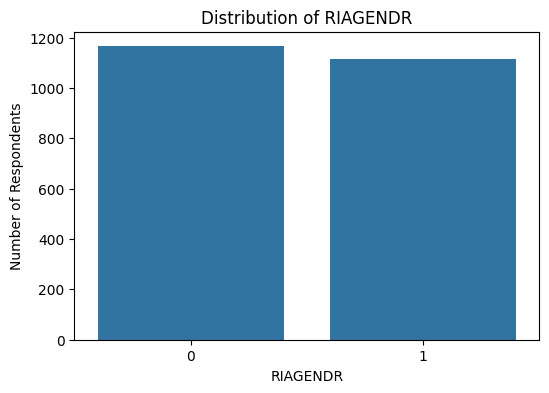

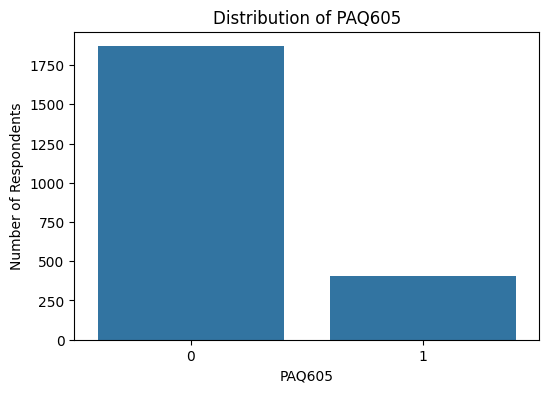

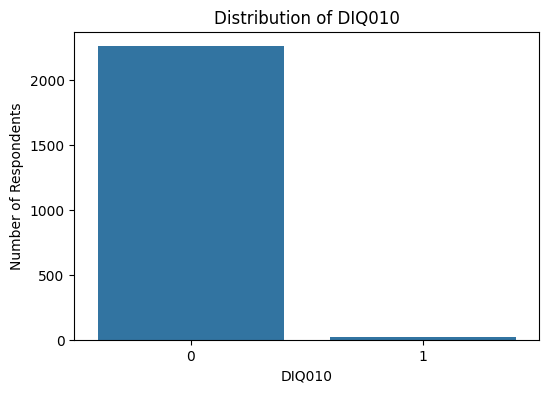

In [29]:
# Bar charts for categorical variables
cat_vars = ['RIAGENDR', 'PAQ605', 'DIQ010']
for var in cat_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[var])
    plt.xlabel(var)
    plt.ylabel('Number of Respondents')
    plt.title(f'Distribution of {var}')
    plt.show()

In [3]:
# Select relevant features
features = ['RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
X = df[features]
y = df['age_group']

# Convert categorical variables
X = pd.get_dummies(X, drop_first=True)
y = y.astype('category').cat.codes

# Split dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 1822, Test samples: 456


In [ ]:
# Decision Tree and Random Forest models
dt_model = DecisionTreeClassifier(min_samples_leaf=2, max_depth=10, random_state=42)
rf_model = RandomForestClassifier(n_estimators=210, min_samples_leaf=2, max_depth=73, random_state=42)

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize performance metrics
dt_results = []
rf_results = []

for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Train Decision Tree
    start_time = time.time()
    dt_model.fit(X_train_cv, y_train_cv)
    dt_time = time.time() - start_time
    dt_preds = dt_model.predict(X_test_cv)
    
    # Train Random Forest
    start_time = time.time()
    rf_model.fit(X_train_cv, y_train_cv)
    rf_time = time.time() - start_time
    rf_preds = rf_model.predict(X_test_cv)

    # Evaluate models
    for model_name, preds, train_time, results in [
        ("Decision Tree", dt_preds, dt_time, dt_results),
        ("Random Forest", rf_preds, rf_time, rf_results)
    ]:
        acc = accuracy_score(y_test_cv, preds)
        prec = precision_score(y_test_cv, preds, average='macro')
        rec = recall_score(y_test_cv, preds, average='macro')
        f1 = f1_score(y_test_cv, preds, average='macro')

        # AUC Calculation
        auc = roc_auc_score(pd.get_dummies(y_test_cv), pd.get_dummies(preds), multi_class='ovr')

        results.append([acc, prec, rec, f1, auc, train_time])

# Convert results to DataFrame
dt_results_df = pd.DataFrame(dt_results, columns=['Accuracy', 'Time', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])
rf_results_df = pd.DataFrame(rf_results, columns=['Accuracy', 'Time', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# Display average performance metrics
print("Decision Tree Mean Metrics:")
print(dt_results_df.mean())

print("Random Forest Mean Metrics:")
print(rf_results_df.mean())

Decision Tree Mean Metrics:
Accuracy     0.803331
Time         0.589209
Precision    0.554855
Recall       0.560442
F1 Score     0.554855
AUC-ROC      0.011290
dtype: float64
Random Forest Mean Metrics:
Accuracy     0.845034
Time         0.715476
Precision    0.565190
Recall       0.575136
F1 Score     0.565190
AUC-ROC      0.804980
dtype: float64


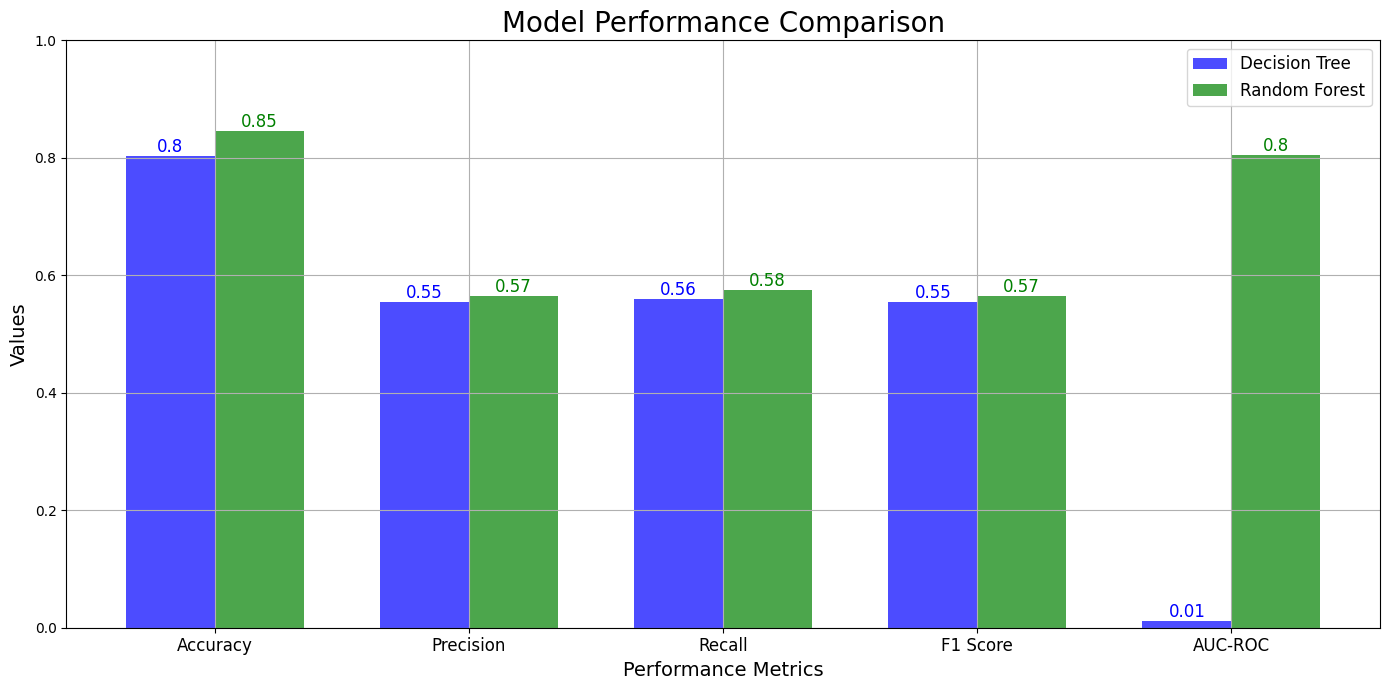

In [34]:
# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
dt_means = dt_results_df[metrics].mean()
rf_means = rf_results_df[metrics].mean()

# Number of metrics
n_metrics = len(metrics)

# Create an array for the x-axis positions
x = np.arange(n_metrics)

# Width of the bars
width = 0.35

# Create the bar plot
plt.figure(figsize=(14, 7))
bars1 = plt.bar(x - width/2, dt_means, width, label='Decision Tree', color='blue', alpha=0.7)
bars2 = plt.bar(x + width/2, rf_means, width, label='Random Forest', color='green', alpha=0.7)

# Add titles and labels
plt.title('Model Performance Comparison', fontsize=20)
plt.xlabel('Performance Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(x, metrics, fontsize=12)
plt.ylim(0, 1)  # Assuming the metrics are between 0 and 1
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Add plot values
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center', fontsize=12, color='blue')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center', fontsize=12, color='green')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

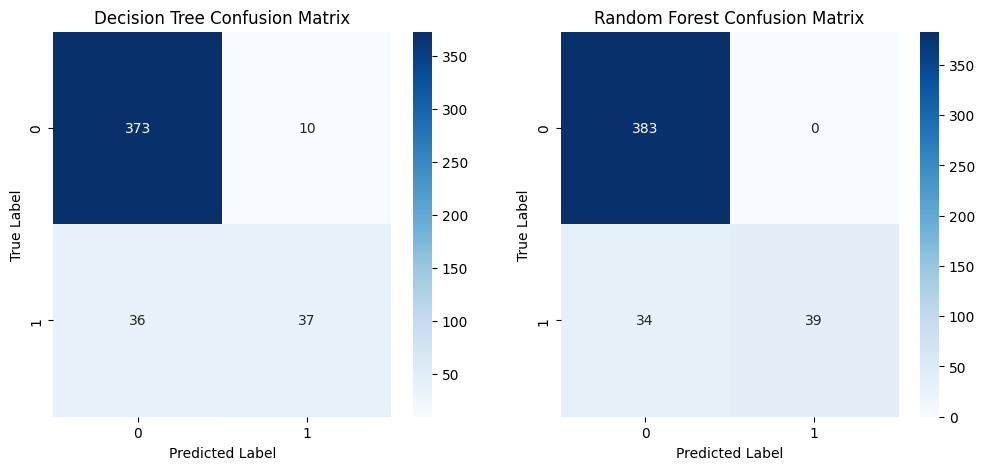

In [18]:
# Confusion Matrices
dt_cm = confusion_matrix(y_test, dt_model.predict(X_test))
rf_cm = confusion_matrix(y_test, rf_model.predict(X_test))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

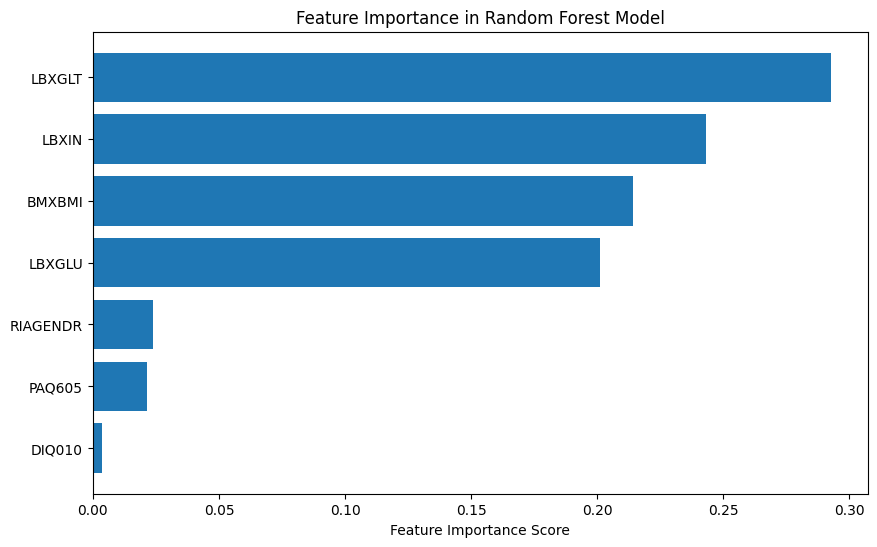

In [19]:
# Feature Importance using Random Forest
rf_importances = rf_model.feature_importances_
sorted_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), rf_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), X.columns[sorted_indices])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

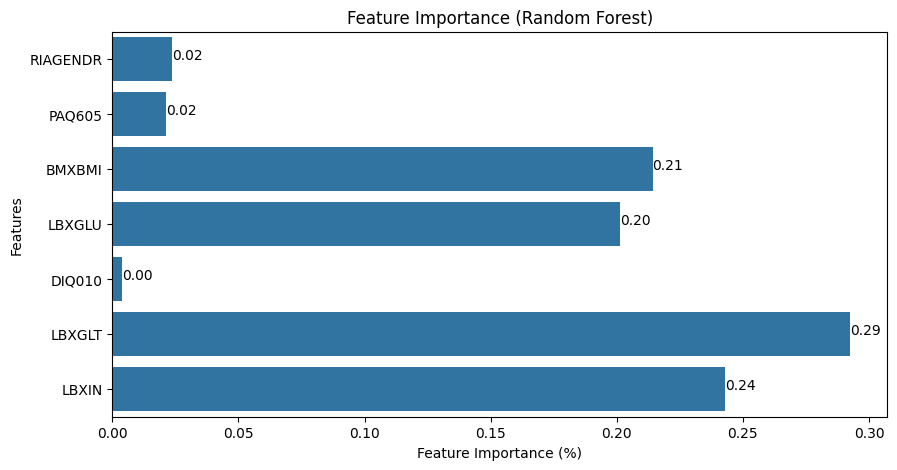

In [ ]:
# Feature Importance using Random Forest (Alternative)
if 'rf_model' in globals():
    feature_importance = rf_model.feature_importances_
    feature_names = rf_model.feature_names_in_

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance, y=feature_names, orient='h')
    plt.xlabel('Feature Importance (%)')
    plt.ylabel('Features')
    plt.title('Feature Importance (Random Forest)')

    for index, value in enumerate(feature_importance):
        plt.text(value, index, f"{value:.2f}")

    plt.show()
else:
    print("Random Forest model not found. Ensure rf_model is trained before running this cell.")